<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/II.%20Introduccion_Ciencia_Datos/2_ProcesoMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proceso para Desarrollar un Proyecto de Machine Learning**



1. Ver el panorama general (aprendizaje supervisado, regresión, etc.)
2. Obtener los datos (separar conjunto de prueba, definir la métrica a usar)
3. Descubrir y visualizar los datos para obtener insights
4. Preparar los datos para los algoritmos de Machine Learning (escala, datos faltantes, datos categóricos)
5. Seleccionar un modelo y entrenarlo
6. Afinar el modelo
7. Presentar la solución
8. Iniciar

**Objetivo**: Predecir el valor medio de las casas en distritos de California. Basado en libro de Aurelien Geron (Hands-On Machine Learning, Second Edition, 2019).

In [101]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



## **1. Ver Panorama General**

**Problema:** Construir un predictor de precios promedios de casa en distritos de California

- ¿Cuál es exactamente el objetivo del negocio? construir un modelo probablemente no sea el objetivo final.
- ¿Cómo espera la empresa utilizar y beneficiarse de este modelo?
- Esto es importante porque determinará cómo se planteará el problema, qué algoritmos seleccionará, qué medida de rendimiento se utilizará para evaluar su modelo y cuánto esfuerzo deberá dedicar a modificarlo.

**Respuesta**: el resultado del modelo (una predicción del precio medio de la vivienda en un distrito) se enviará a otro sistema de ML, junto con otras entradas. Este sistema posterior determinará si vale la pena invertir en un área determinada o no. Esto afecta directamente a los ingresos.

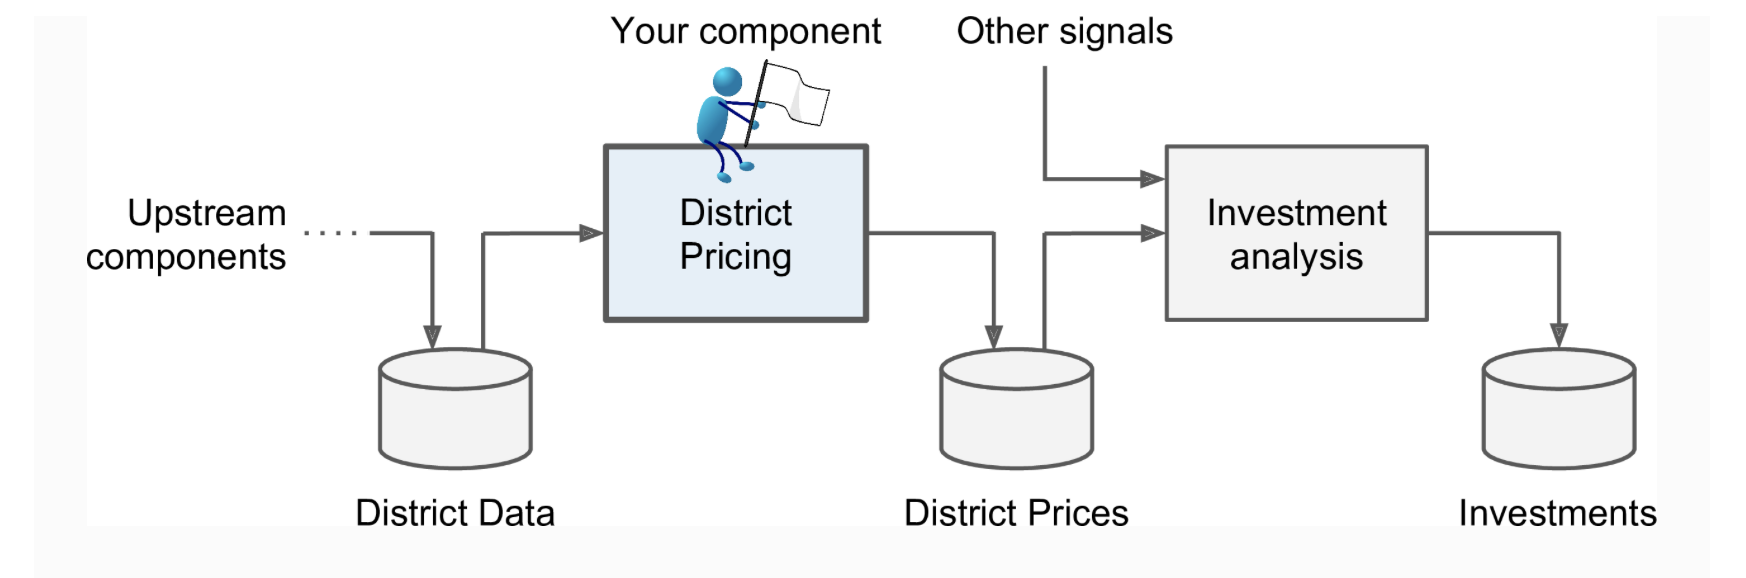


**Definición del problema**

- Es claramente una tarea de aprendizaje supervisado, cada instancia viene con el resultado esperado, es decir, el precio medio de la vivienda en el distrito.

- Es una tarea de regresión típica, ya que se le pide que prediga un valor.
- Específicamente, se trata de un problema de regresión múltiple ya que el sistema utilizará múltiples variables para hacer una predicción (utilizará la población del distrito, el ingreso medio, etc.).
- No hay un flujo continuo de datos que ingresa al sistema, son datos del censo de 1990, por lo que es aprendizaje offline.

**Selección de Métricas**

Una medida de rendimiento típica para problemas de regresión es el error cuadrático medio (RMSE). Da una idea de cuánto error suele cometer el sistema en sus predicciones, con una mayor ponderación para los errores grandes.

$$RMSE(\mathbf{X},h) = \sqrt{\frac{1}{m}\Sigma_{i=1}^{m}{\Big(h(\mathbf{x}^{(i)}) -y^{(i)}\Big)^2}}$$

- $m$, indica número de ejemplos
- $h$, hipótesis o modelo de ML usado
- $\mathbf{x}^{(i)}$, vector de características (ejemplo i-ésimo, sin considerar la variable objetivo)
- $y^{(i)}$, variable objetivo a predecir, respuesta correcta asociada al ejemplo i-ésimo.
- $\mathbf{X}$, matriz con todos los $m$ ejemplos

Aunque el RMSE es generalmente la medida de rendimiento preferida para tareas de regresión, en algunos contextos es posible que prefieras utilizar otra función.

Por ejemplo, supongamos que hay muchos distritos outliers. En ese caso, puede considerar utilizar el error absoluto medio (MAE).

$$MAE(\mathbf{X},h) = \frac{1}{m}\sum_{i=1}^{m}|h(\mathbf{x}^{(i)}-y^{(i)}|$$

## **2. Obtención de los Datos**

Download de los datos

In [102]:
datos = pd.read_csv("https://raw.githubusercontent.com/eduardool/MaestriaCienciaDatos/main/datasets/housing.csv")

In [103]:
datos.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [104]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [105]:
#total_bedrooms es la variable donde le faltan datos, hay celdas nulas.
vacio_bedrooms=datos['total_bedrooms'].isnull().sum()
print('El total de registros nulos de la columna total_bedrooms es:',vacio_bedrooms)

El total de registros nulos de la columna total_bedrooms es: 207


Observar que hay datos incompletos, y hay una variable categórica

In [106]:
datos["ocean_proximity"].value_counts()#value counts cuanta las categorias repetidas.

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [107]:
datos["ocean_proximity"].value_counts()*100/len(datos)

<1H OCEAN     44.263566
INLAND        31.739341
NEAR OCEAN    12.877907
NEAR BAY      11.094961
ISLAND         0.024225
Name: ocean_proximity, dtype: float64

In [108]:
datos.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [109]:
#Total_bedrooms tiene como promedio 537.87
print('El promedio de bedrooms es:', datos['total_bedrooms'].mean())
print('EL media de bedrooms es:', datos['total_bedrooms'].median())
print('El total de bedrooms es:', datos['total_bedrooms'].sum())

El promedio de bedrooms es: 537.8705525375618
EL media de bedrooms es: 435.0
El total de bedrooms es: 10990309.0


In [110]:
10990309.0/20433#El promedio que calcula el describe, no considera los valores nulos.

537.8705525375618

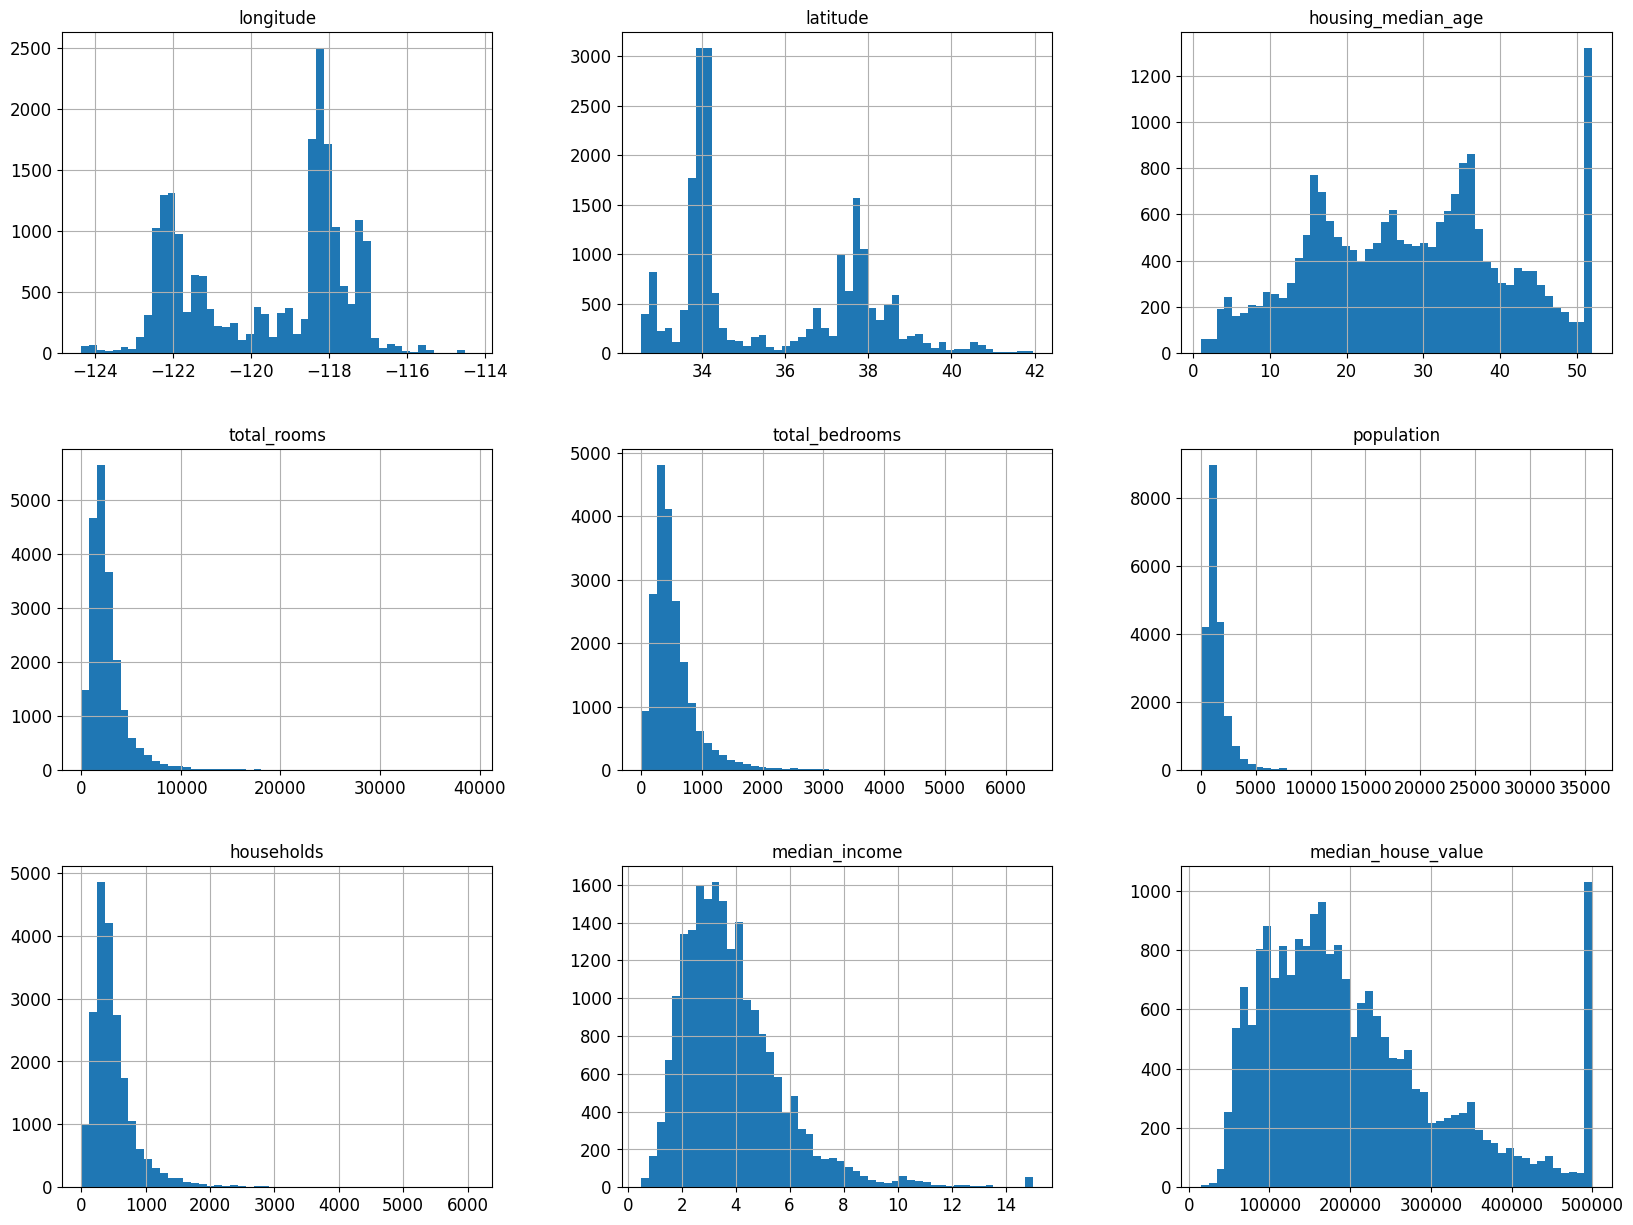

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
datos.hist(bins=50, figsize=(20,15))
plt.show()

**Crear Conjunto de Prueba**

In [112]:
from sklearn.model_selection import train_test_split

entrenamiento, prueba = train_test_split(datos, test_size=0.2, random_state=42)#se puede usar cualquier número en random_state
#lo importante es que se use siempre el mismo número.

In [113]:
entrenamiento.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [114]:
print('Total del conjunto de entrenamiento:',len(entrenamiento))
print('Total del conjunto de prueba:',len(prueba))
print('Total del conjunto de datos:',len(datos))
print('Porcentaje de datos de prueba o test:',len(prueba)/len(datos))
print('Porcentaje de datos de entrenamiento:',len(entrenamiento)/len(datos))

Total del conjunto de entrenamiento: 16512
Total del conjunto de prueba: 4128
Total del conjunto de datos: 20640
Porcentaje de datos de prueba o test: 0.2
Porcentaje de datos de entrenamiento: 0.8


In [115]:
#Ejemplo de estratificación agarrando intervalos de valores y llamandolos nuevas categorías.
num = [0, 100, 10, 15, 6, 8, 10, 12, 5, 9]#conjunto de valores
bins = [-1, 5, 10, 101]#intervalos (0-5) de (6-10) de (11-15)
categories = pd.cut(num, bins, labels=['Low', 'Medium', 'High'])

In [116]:
categories

['Low', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low', 'Medium']
Categories (3, object): ['Low' < 'Medium' < 'High']

**Definir un conjunto de prueba estratificado**

Asumiendo que la variable más representativa del problema es Median_income:

<Axes: >

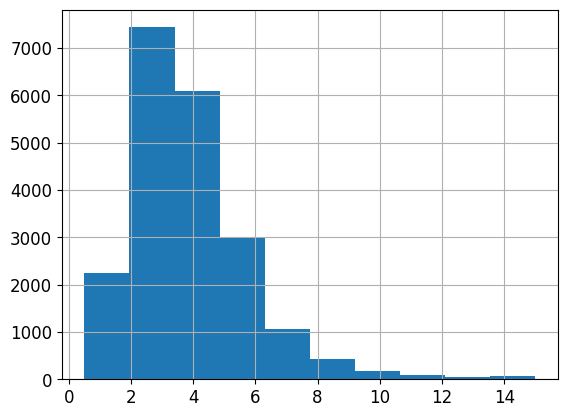

In [117]:
datos["median_income"].hist()

Creación de categorías

In [118]:
datos["income_cat"] = pd.cut(datos["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],#los bins son los intervalos
                               labels=[1, 2, 3, 4, 5])#labels son las nuevas categorías podria ser a, b,c,d y e
                               #que representan a los intervalos o bins determinados

<Axes: >

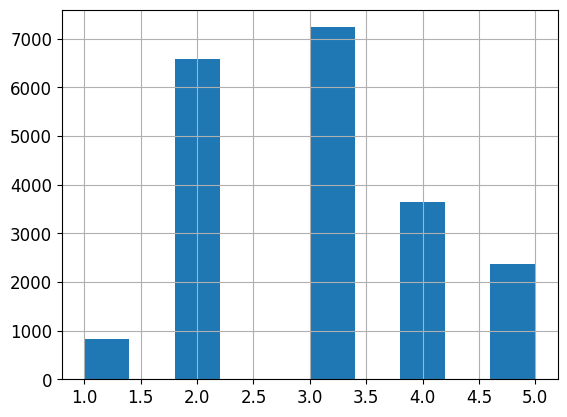

In [119]:
#datos["income_cat"].value_counts()
datos["income_cat"].hist()

In [120]:
datos.head(5)#tenemos una nueva columna (income_cat) que nombran los intervalos creados de la variable median_income

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


###ESTRATIFICAMOS

In [121]:
from sklearn.model_selection import StratifiedShuffleSplit#define las proporciones de forma adecuada
#El conjunto de prueba continua con el 20% pero ahora es estratificado
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(datos, datos["income_cat"]):#estratificar según a datos["income_cat"]
    entrenamiento_estrat = datos.loc[train_index]
    prueba_estrat = datos.loc[test_index]

In [122]:
print('Conjunto de datos de entrenamiento_estratificado:', len(entrenamiento_estrat))
print('Conjunto de datos de pruebas_estratificado:', len(prueba_estrat))
print('Conjunto total de datos:', len(datos))
print('Proporción de datos de entrenamiento:',len(entrenamiento_estrat)/len(datos))
print('Proporción de datos de prueba:',len(prueba_estrat)/len(datos))

Conjunto de datos de entrenamiento_estratificado: 16512
Conjunto de datos de pruebas_estratificado: 4128
Conjunto total de datos: 20640
Proporción de datos de entrenamiento: 0.8
Proporción de datos de prueba: 0.2


In [123]:
prueba_estrat["income_cat"].value_counts()#de la categoría 3 hay 1447, de la 2 hay 1316 y de la categoría 1 hay 165

3    1447
2    1316
4     728
5     472
1     165
Name: income_cat, dtype: int64

In [124]:
#Proporción del conjunto de pruebas estratificado(intervalos que pertenecen a las categorías 1,2,3,4,5)
prueba_estrat["income_cat"].value_counts()/len(prueba_estrat)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [125]:
#Proporción estratificado del total de datos que pertenecen a las categorías 1,2,3,4,5
#datos["income_cat"].value_counts() / len(datos)

In [126]:
entrenamiento_estrat["income_cat"].value_counts() / len(entrenamiento_estrat)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

Comparación de conjuntos de pruebas estratificado y normal

In [127]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

conj_entren, conj_prueba = train_test_split(datos, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "General": income_cat_proportions(datos),#proporcion del estratificado pero del total
    "Estratificado_prueba": income_cat_proportions(prueba_estrat),#proporcion del estratificado pero de conj de prueba
    "Aleatorio_prueba": income_cat_proportions(conj_prueba),#es una distribución aleatoria
}).sort_index()
compare_props["%error Aleatorio"] = 100 * compare_props["Aleatorio_prueba"] / compare_props["General"] - 100
compare_props["%error Estratificado"] = 100 * compare_props["Estratificado_prueba"] / compare_props["General"] - 100

In [128]:
compare_props
#general(considerando el estratificado) estratificado (del conjunto de prueba), aleatorio (del conjunto de prueba)

,General,Estratificado_prueba,Aleatorio_prueba,%error Aleatorio,%error Estratificado
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [129]:
#de los errores se puede apreciar que al estratificar, el error es menor que si solo fuera aleatorio.

In [130]:
# Elimina variable categórica (income_cat) creada para el conj. estratificado tanto de entrenamiento y prueba
for set_ in (entrenamiento_estrat, prueba_estrat):
    set_.drop("income_cat", axis=1, inplace=True)

In [131]:
entrenamiento_estrat.head(3)#se eliminó la variable income_cat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND


In [132]:
prueba_estrat.head(3)#también del conjunto de prueba se eliminó la variable creada (income_cat)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN


## **3. Descubrir y visualizar datos para obtener insights**

In [133]:
#trabajaremos en adelante con el conjunto de entrenamiento producto de la estratificación
datos = entrenamiento_estrat.copy()


<Axes: xlabel='longitude', ylabel='latitude'>

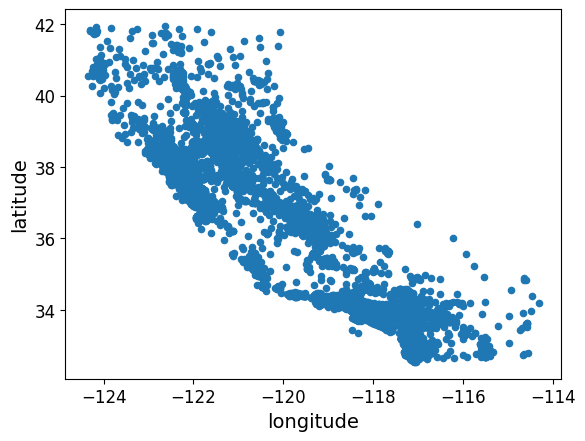

In [134]:
datos.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

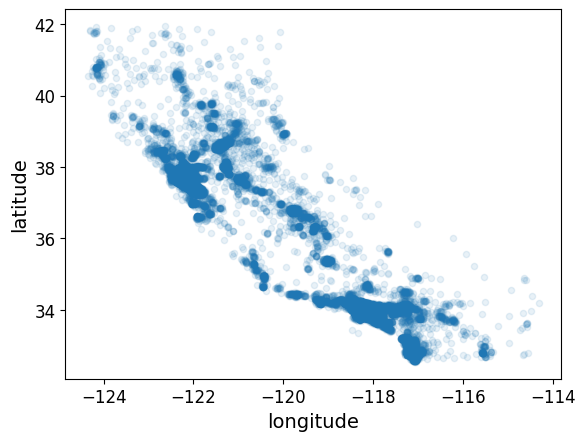

In [135]:
datos.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Mostrar ahora el gráfico de acuerdo al precio medio de las casas


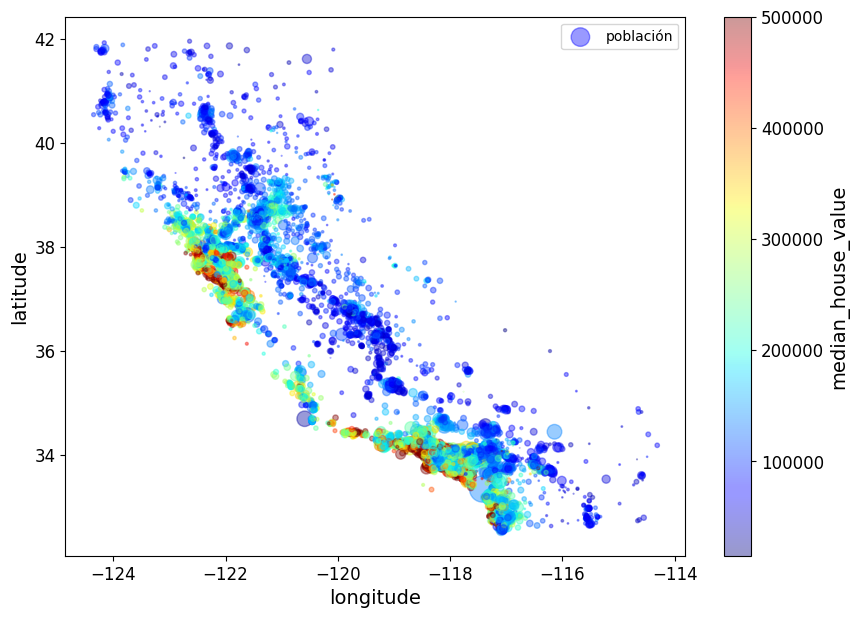

In [136]:
datos.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=datos["population"]/100, label="población", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

In [137]:
# Ejercicio mostrar sobre el mapa de California

Búsqueda de correlaciones

In [138]:
matriz_corr = datos.corr()

<ipython-input-138-1272d01ef6b5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_corr = datos.corr()


In [139]:
matriz_corr["median_house_value"].sort_values(ascending=False)#la correlación se toma según a la variable objetivo

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

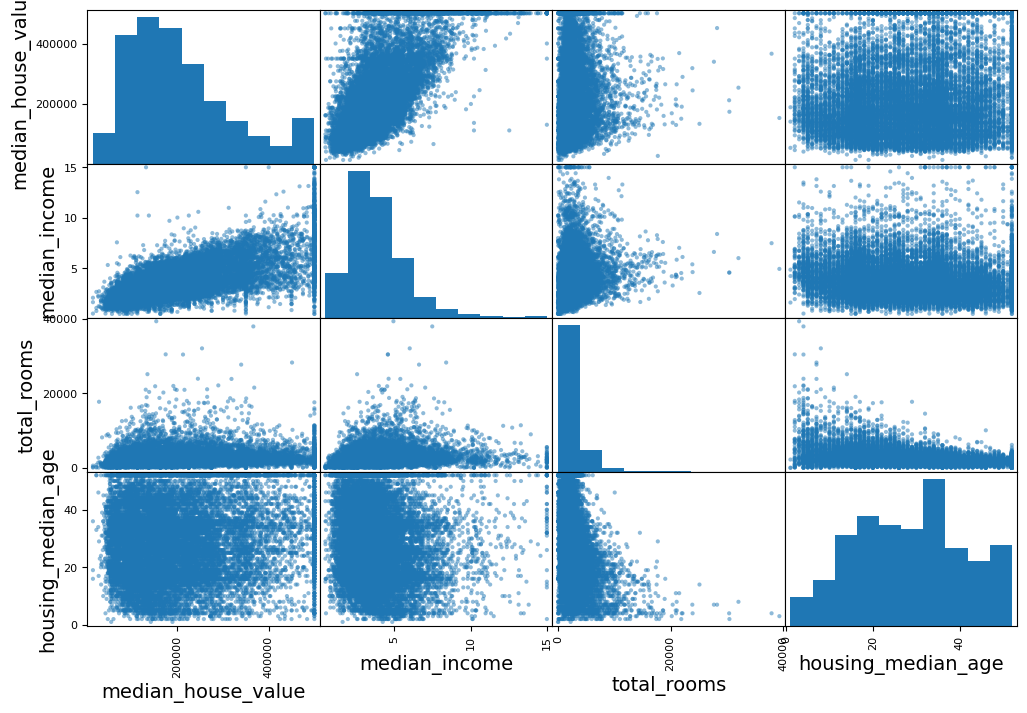

In [140]:
from pandas.plotting import scatter_matrix

variables = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(datos[variables], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

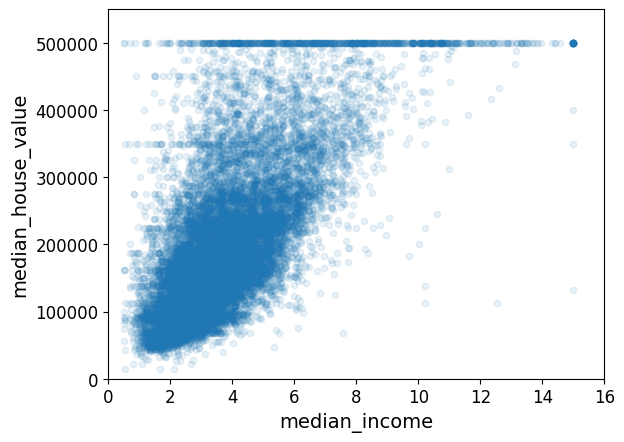

In [141]:
# La más correlacionada
datos.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

### Construcción de atributos nuevos

In [142]:
datos["rooms_per_household"] = datos["total_rooms"]/datos["households"]#promedio de ambientes por familias
datos["bedrooms_per_room"] = datos["total_bedrooms"]/datos["total_rooms"]#relacion de habitaciones con los ambientes
datos["population_per_household"]=datos["population"]/datos["households"]#promedio de personas por cada casa o familias

In [143]:
matriz_corr = datos.corr()
matriz_corr["median_house_value"].sort_values(ascending=False)

<ipython-input-143-b4e39b495697>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_corr = datos.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [144]:
datos.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333


Ahora se tiene una variable con una correlación mayor rooms_per_household

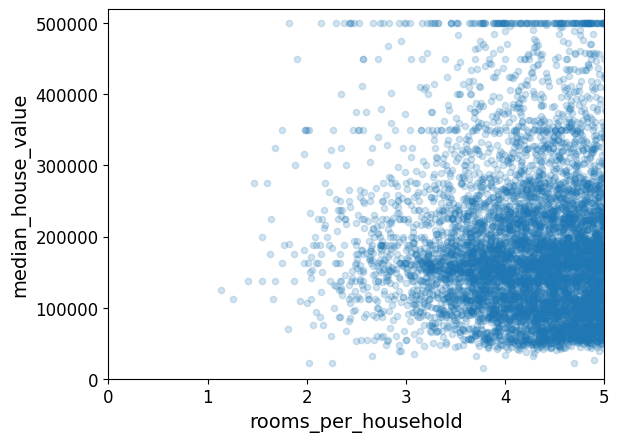

In [145]:
datos.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## **4. Preparar los datos para los algoritmos de Machine Learning**

In [147]:
entrenamiento_estrat.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND


In [159]:
X_entrenamiento = entrenamiento_estrat.drop("median_house_value", axis=1) #Es el X del modelo
y_entrenamiento = entrenamiento_estrat["median_house_value"].copy()#Es el Y del modelo

In [160]:
X_entrenamiento.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND


In [161]:
y_entrenamiento.head(3)

12655     72100.0
15502    279600.0
2908      82700.0
Name: median_house_value, dtype: float64

In [162]:
X_entrenamiento.shape

(16512, 9)



> #### **Datos faltantes**
Hay 3 posibles alternativas:

>
> - Borrar filas `datos.dropna(subset=["total_bedrooms"])    # opción 1 `
> - Borras columnas `datos.drop("total_bedrooms", axis=1)       # opción 2 `
> - Completar `mediana = datos["total_bedrooms"].median()  # opción 3 `
>>  `datos["total_bedrooms"].fillna(mediana, inplace=True)`

>  Se trabajará en una copia para demostrar estas opciones.

In [163]:
filas_incompletas_muestra = X_entrenamiento[X_entrenamiento.isnull().any(axis=1)]
filas_incompletas_muestra

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,NaN,3207.0,1012.0,4.0767,INLAND
4691,-118.37,34.07,50.0,2519.0,NaN,1117.0,516.0,4.3667,<1H OCEAN
9149,-118.50,34.46,17.0,10267.0,NaN,4956.0,1483.0,5.5061,<1H OCEAN
16757,-122.48,37.70,33.0,4492.0,NaN,3477.0,1537.0,3.0546,NEAR OCEAN


In [50]:
filas_incompletas_muestra.shape

(158, 9)

In [51]:
filas_incompletas_muestra.dropna(subset=["total_bedrooms"])    # option 1, elimina las filas o registros con NaN

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [52]:
filas_incompletas_muestra.drop("total_bedrooms", axis=1)  # opción 2, elimina la columna donde se encuentre los NaN

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN
...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,3207.0,1012.0,4.0767,INLAND
4691,-118.37,34.07,50.0,2519.0,1117.0,516.0,4.3667,<1H OCEAN
9149,-118.50,34.46,17.0,10267.0,4956.0,1483.0,5.5061,<1H OCEAN
16757,-122.48,37.70,33.0,4492.0,3477.0,1537.0,3.0546,NEAR OCEAN


In [53]:
mediana = X_entrenamiento["total_bedrooms"].median()
filas_incompletas_muestra["total_bedrooms"].fillna(mediana, inplace=True) # opción 3
filas_incompletas_muestra

<ipython-input-53-7131759028e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filas_incompletas_muestra["total_bedrooms"].fillna(mediana, inplace=True) # opción 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,433.0,3207.0,1012.0,4.0767,INLAND
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667,<1H OCEAN
9149,-118.50,34.46,17.0,10267.0,433.0,4956.0,1483.0,5.5061,<1H OCEAN
16757,-122.48,37.70,33.0,4492.0,433.0,3477.0,1537.0,3.0546,NEAR OCEAN


**Usar Imputer para llenar datos**

In [54]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")#imputar los datos usando la mediana

Remover atributos de texto, porque la mediana solo puede aplicarse en atributos numéricos:

In [55]:
X_num = X_entrenamiento.drop('ocean_proximity', axis=1)#consideramos solo variables numéricas, quitamos las categóricas

In [56]:
imputer.fit(X_num)

SimpleImputer(strategy='median')

In [57]:
imputer.statistics_#calcula la mediana de las variables numericas

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [58]:
# Verificar las medianas calculadas con imputer
X_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [59]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [60]:
X_num.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750


**Transformar el conjunto de entrenamiento:**

In [61]:
X = imputer.transform(X_num)#Nos devuelve un array, el array se debe pasar a un dataframe
X

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [62]:
X_trans = pd.DataFrame(X, columns=X_num.columns,
                          index=X_num.index)

In [63]:
#X_trans#Nos muestra todo el conjunto de entrenamiento ya con los valores imputados
X_trans.info() #aca ya se tienen los datos de entrenamientos imputados

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [64]:
X_trans.loc[filas_incompletas_muestra.index.values]#solo muestra los registros que fueron imputados.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580
...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,433.0,3207.0,1012.0,4.0767
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667
9149,-118.50,34.46,17.0,10267.0,433.0,4956.0,1483.0,5.5061
16757,-122.48,37.70,33.0,4492.0,433.0,3477.0,1537.0,3.0546


In [65]:
imputer.strategy

'median'

In [66]:
X_trans = pd.DataFrame(X, columns=X_num.columns,
                          index=X_num.index)
X_trans.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [67]:
X_trans.shape

(16512, 8)

In [68]:
X_entrenamiento["ocean_proximity"].unique()

array(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'ISLAND'],
      dtype=object)

**Variables Categóricas**

In [69]:
X_cat = X_entrenamiento[["ocean_proximity"]]# X_cat devuelve data frame solo con la columna categorica(ocean_proximity)
X_cat.head(10)


,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [70]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
X_cat_encoded = ordinal_encoder.fit_transform(X_cat)
X_cat_encoded[:10]#fueron codificados como 0,1,2,3 y 4 las categoricas, pero no sirve este tipo de encoded por el sesgo
#de pesos que introducen los pesos

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [71]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**OneHotEncoder nos permite transformar en one-hots:**

In [72]:
#[0 1 2] # 3 categorias
#[1 0 0] -> 0
#[0 1 0] -> 1
#[0 0 1] -> 2
#lo correcto es agregar columnas por cada categoria diferente y se le asigne 1 cada que aparece y cero a lo demas
#a ello se le denomina oneHotEncoder

In [73]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

OneHotEncoder retorna una matriz dispersa, la cual puede convertise en matriz densa:

In [74]:
X_cat_1hot.toarray()#se crean 5 columnas con ceros y unos

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternativa, colocar el parámetro `sparse` en False

In [75]:
cat_encoder = OneHotEncoder(sparse_output=False)
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**Construcción de Transformer para adicionar atributos**

In [76]:
#codigo para agregar variables nuevas

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):#añadimos las variables nuevas
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(X_entrenamiento.values)

Se puede obtener los índices (3, 4, 5, 6) de forma dinámica

In [78]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    X_entrenamiento.columns.get_loc(c) for c in col_names] # obtiene índices de las columnas requeridas

In [79]:
rooms_ix

3

El resultado es un Numpy arrat housing_extra_attribs que pierde los nombres de las columnas ( un problema con Scikit-Learn). Para recuperar el Dataframe se puede hacer esto:

In [80]:
X_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(X_entrenamiento.columns)+["rooms_per_household", "population_per_household"],
    index=X_entrenamiento.index)
X_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


**Pipelines de Transformación**


Se define un pipeline para pre-procesar los atributos numéricos:

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),#imputar con la mediana
        ('attribs_adder', CombinedAttributesAdder()),#añadir nuevs varibales producto del calculo de las existentes
        ('std_scaler', StandardScaler()),#luego escala entre 0 y 1
    ])

X_num_tr = num_pipeline.fit_transform(X_num)

In [82]:
X_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [83]:
num_attribs = list(X_num)#X_num es un dataframe con los valores nulos imputados
num_attribs#list de un dataframe solo nos devuelve el nombre de las columnas

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

Construcción del pipeline completo

In [84]:
from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_preparado = full_pipeline.fit_transform(X_entrenamiento)

In [85]:
X_preparado

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [86]:
X_preparado.shape

(16512, 16)

## **5. Seleccionar y entrenar modelos**

Entrenamiento y Evaluación en el conjunto de entrenamiento

In [87]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression()

reg_lin.fit(X_preparado, y_entrenamiento)#al modelo sólo ingresa el conjunto de datos de entrenamiento




LinearRegression()

In [88]:
# prueba con algunas instancias pequeñas
pocos_X = X_entrenamiento.iloc[:5]
pocos_y = y_entrenamiento.iloc[:5]

pocos_datos_preparados = full_pipeline.transform(pocos_X)

print("Predicciones:", reg_lin.predict(pocos_datos_preparados))

#valores predichos o del modelo

Predicciones: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [89]:
y_entrenamiento.iloc[:5]

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64

In [ ]:
#Comparar a los valores reales:
print("y real:", list(pocos_y))

y real: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


**Métricas**

RMSE

In [90]:
from sklearn.metrics import mean_squared_error

predicciones_X = reg_lin.predict(X_preparado)#valores predichos luego de la predicción
lin_mse = mean_squared_error(y_entrenamiento, predicciones_X)#y_entrenamiento valores reales, predicicones_X valores predichos
lin_rmse = np.sqrt(lin_mse)
lin_rmse




68627.87390018745

MAE

In [91]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_entrenamiento, predicciones_X)
lin_mae

49438.66860915803

**Prueba de otro modelo**

Arbol de Regresión

In [92]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)

tree_reg.fit(X_preparado, y_entrenamiento)

DecisionTreeRegressor(random_state=42)

In [94]:
housing_predictions = tree_reg.predict(X_preparado)
#REVISAR SALE CERO
tree_mse = mean_squared_error(y_entrenamiento,predicciones_X)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

68627.87390018745

In [95]:
housing_predictions

array([ 72100., 279600.,  82700., ..., 140400., 258100.,  62700.])

In [96]:
y_entrenamiento

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

**Mejor Evaluación: Validación Cruzada**

Cross Validation: 5 folds
![texto alternativo](https://camo.githubusercontent.com/078f46a263e05a48f9afb8b39d497bfefbec5cff/68747470733a2f2f7363696b69742d6c6561726e2e6f72672f737461626c652f5f696d616765732f677269645f7365617263685f63726f73735f76616c69646174696f6e2e706e67)

In [ ]:
#verificar inicialmente daba cero el tree_rms

In [99]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_preparado, y_entrenamiento,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

**Resultados de Validación Cruzada - Árboles de Regresión**

In [102]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


**Resultados de Validación Cruzada - Regresión Lineal Multivariada**

In [104]:
lin_scores = cross_val_score(reg_lin, X_preparado, y_entrenamiento,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


**Regresión Lineal es mejor que árbol de decisión para este conjunto de datos (tiene un promedio de RMSE menor)**

Resultados de Validación Cruzada - Random Forest

In [105]:
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf.fit(X_preparado, y_entrenamiento)

RandomForestRegressor(random_state=42)

In [108]:
predicciones_X = reg_rf.predict(X_preparado)
forest_mse = mean_squared_error(y_entrenamiento, predicciones_X)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [109]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(reg_rf, X_preparado, y_entrenamiento,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)




Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


*Prueba con SVR*

In [112]:
from sklearn.svm import SVR

reg_svr = SVR(kernel="rbf")#preguntar porque el kernel es rbf
reg_svr.fit(X_preparado, y_entrenamiento)
predicciones_X = reg_svr.predict(X_preparado)

svr_mse = mean_squared_error(y_entrenamiento, predicciones_X)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118578.69234925653

**Probar SVR con Cross Validation**

## **6. Afinar del Modelo Seleccionado**

El modelo seleccionado es Random Forest, se debe realizar un proceso de afinamiento

- Búsqueda en Grid

In [113]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # Se prueba 12 (3×4) combinaciones de hiperparámetros
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # entonces intentar 6 (2×3) combinaciones con bootstrap en False (sampling con reemplazo y sin reemplazo)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

reg_forest = RandomForestRegressor(random_state=42)
# Al usar cv  5 en total son (12+6)*5=90 entrenamientos
grid_search = GridSearchCV(reg_forest, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_preparado, y_entrenamiento)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

La mejor combinación de parámetros

In [1246]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [1247]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [1248]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
# Combinación de resultados obtenidos durante la búsqueda

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

- Búsqueda Aleatoria de hiperparámetros

In [1249]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

reg_forest = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(reg_forest, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_preparado, y_entrenamiento)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c242ce864a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c242cb8f010>},
                   random_state=42, scoring='neg_mean_squared_error')

Mejores modelos

In [1250]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


**Selección del Modelo Final**

In [1251]:
modelo_final = grid_search.best_estimator_

# recien recupero el conjunto de prueba
X_prueba = prueba_estrat.drop("median_house_value", axis=1)
y_prueba = prueba_estrat["median_house_value"].copy()

X_prueba_preparado = full_pipeline.transform(X_prueba)
predicciones_finales = modelo_final.predict(X_prueba_preparado)

final_mse = mean_squared_error(y_prueba, predicciones_finales)
final_rmse = np.sqrt(final_mse)

In [1252]:
final_rmse

47873.26095812988

**Serializar Modelo**

In [1253]:
import joblib

joblib.dump(modelo_final, "modelo_final.pkl")
joblib.dump(full_pipeline, "full_pipeline.pkl")

# despues ...
#modelo_final_ = joblib.load("modelo_final.pkl")
#full_pipeline_ = joblib.load("modelo_final.pkl")



['full_pipeline.pkl']